C:\Users\tnlab\AppData\Local\Temp\ipykernel_17892\1466589936.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10")


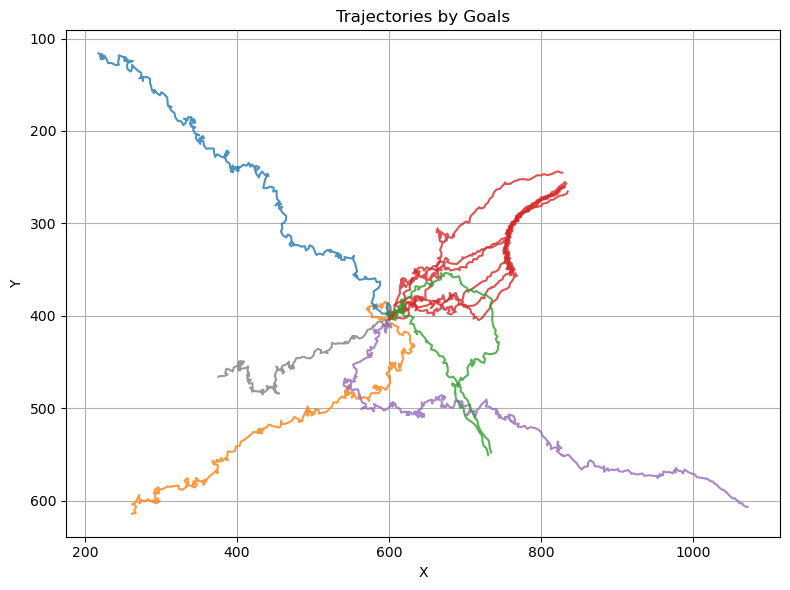

===== Trajectory Metrics by Mode =====
Mode=Manual
  Success Rate:           66.67%  (2/3)
  Average Time:           6.44 s
  Average Path Efficiency:0.39
  Average Throughput:     0.84 bits/s

Mode=AI
  Success Rate:           100.00%  (9/9)
  Average Time:           3.47 s
  Average Path Efficiency:0.52
  Average Throughput:     1.27 bits/s



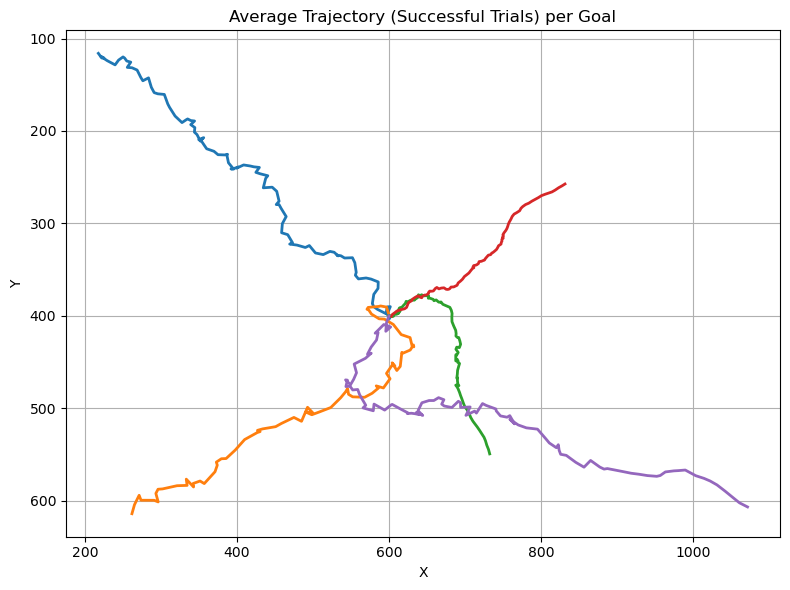

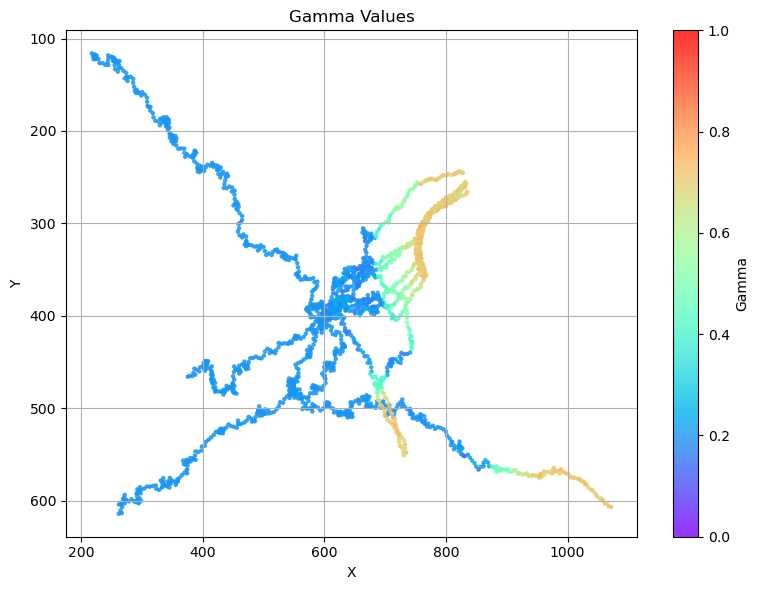

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import math

###############################################################################
# 1. LOAD DATA
###############################################################################
file_path = r"D:\CODE\cursor\End-Effector-Test-Environment\End-Effector-Test-Environment\user study data\data_log_20250304_161809.json"
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
    exit()

with open(file_path, "r") as f:
    data_log = json.load(f)

if not data_log:
    print("No trials found in data_log.")
    exit()

###############################################################################
# 2. GATHER UNIQUE GOALS & ASSIGN COLORS
###############################################################################
unique_goals = set()
for trial in data_log:
    goal = trial.get("goal_reached")
    if goal is not None:
        unique_goals.add(tuple(goal))  # convert list->tuple for hashing
unique_goals = sorted(list(unique_goals))  # consistent ordering

cmap = plt.cm.get_cmap("tab10")
goal_colors = {}
for i, g in enumerate(unique_goals):
    color = cmap(i % 10)
    goal_colors[g] = color

###############################################################################
# 3. PLOT RAW TRAJECTORIES
###############################################################################
plt.figure(figsize=(8, 6))
used_labels = set()

for trial in data_log:
    trajectory = trial.get("trajectory", [])
    if not trajectory:
        continue

    # Trajectory is expected as (x, y, gamma), but for the line plots we use only x,y.
    xs = [pt[0] for pt in trajectory]
    ys = [pt[1] for pt in trajectory]

    outcome = trial.get("trial_outcome")
    goal = trial.get("goal_reached")

    if outcome == "success" and goal is not None:
        goal_tuple = tuple(goal)
        line_color = goal_colors.get(goal_tuple, "black")
        label_text = f"Goal {goal_tuple}"
    else:
        line_color = "grey"
        label_text = "Failure/Reset"

    # Add each label only once
    label = label_text if label_text not in used_labels else None
    used_labels.add(label_text)

    plt.plot(xs, ys, color=line_color, linewidth=1.5, alpha=0.8, label=label)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Trajectories by Goals")
plt.gca().invert_yaxis()  # If your screen coords go top->down
plt.grid(True)
plt.tight_layout()
plt.show()

###############################################################################
# 4. COMPUTE QUALITY METRICS
###############################################################################
dot_diameter = 30.0  # If DOT_RADIUS=15

fitts_metrics = []
for trial in data_log:
    outcome = trial.get("trial_outcome")
    if outcome != "success":
        continue  # Only compute metrics for successful trials
    traj = trial.get("trajectory", [])
    if len(traj) < 2:
        continue

    T = trial.get("trial_duration", None)
    if T is None or T <= 0:
        continue

    traj_np = np.array(traj)
    path_length = 0.0
    for i in range(len(traj_np) - 1):
        x1, y1 = traj_np[i][0], traj_np[i][1]
        x2, y2 = traj_np[i+1][0], traj_np[i+1][1]
        path_length += math.hypot(x2 - x1, y2 - y1)

    start_x, start_y = traj_np[0][0], traj_np[0][1]
    end_x, end_y     = traj_np[-1][0], traj_np[-1][1]
    direct_dist      = math.hypot(end_x - start_x, end_y - start_y)

    if path_length < 1e-9:
        continue

    # Fitts’ ID using path length
    ID = math.log2(path_length / dot_diameter + 1.0)
    throughput = ID / T if T > 0 else float('nan')

    path_efficiency = direct_dist / path_length if path_length > 0 else 0.0
    avg_speed = path_length / T
    overshoot = path_length - direct_dist

    # Simple angle-change measure
    angle_changes = []
    for i in range(1, len(traj_np) - 1):
        ax = traj_np[i][0] - traj_np[i-1][0]
        ay = traj_np[i][1] - traj_np[i-1][1]
        bx = traj_np[i+1][0] - traj_np[i][0]
        by = traj_np[i+1][1] - traj_np[i][1]
        mag_a = math.hypot(ax, ay)
        mag_b = math.hypot(bx, by)
        if mag_a > 1e-9 and mag_b > 1e-9:
            dot_ab = ax*bx + ay*by
            cos_theta = dot_ab / (mag_a*mag_b)
            cos_theta = max(-1.0, min(1.0, cos_theta))
            angle = math.acos(cos_theta)
            angle_changes.append(angle)
    total_angle_change = sum(angle_changes)

    fitts_metrics.append({
        "mode": trial.get("mode", "Unknown"),  # "Manual" or "AI"
        "goal_reached": trial.get("goal_reached"),
        "time": T,
        "path_length": path_length,
        "direct_distance": direct_dist,
        "path_efficiency": path_efficiency,
        "avg_speed": avg_speed,
        "overshoot": overshoot,
        "ID": ID,
        "throughput": throughput,
        "angle_change_sum": total_angle_change
    })

###############################################################################
# 5. PRINT OR PLOT METRICS (Including Average Time, plus Success Rate)
###############################################################################
from collections import defaultdict

success_count_by_mode = defaultdict(int)
total_count_by_mode   = defaultdict(int)

for trial in data_log:
    mode = trial.get("mode", "Unknown")
    outcome = trial.get("trial_outcome")
    total_count_by_mode[mode] += 1
    if outcome == "success":
        success_count_by_mode[mode] += 1

if not fitts_metrics:
    print("No successful trials with valid data to compute metrics.")
else:
    metrics_by_mode = defaultdict(list)
    for fm in fitts_metrics:
        metrics_by_mode[fm["mode"]].append(fm)

    print("===== Trajectory Metrics by Mode =====")
    for mode, data_list in metrics_by_mode.items():
        if not data_list:
            continue

        total_for_mode = total_count_by_mode[mode]
        successes_for_mode = success_count_by_mode[mode]
        success_rate = 0.0
        if total_for_mode > 0:
            success_rate = successes_for_mode / total_for_mode * 100.0

        time_mean = np.mean([d["time"] for d in data_list])
        path_len_mean = np.mean([d["path_length"] for d in data_list])
        eff_mean = np.mean([d["path_efficiency"] for d in data_list])
        speed_mean = np.mean([d["avg_speed"] for d in data_list])
        throughput_mean = np.mean([d["throughput"] for d in data_list])
        angle_mean = np.mean([d["angle_change_sum"] for d in data_list])

        print(f"Mode={mode}")
        print(f"  Success Rate:           {success_rate:.2f}%  ({successes_for_mode}/{total_for_mode})")
        print(f"  Average Time:           {time_mean:.2f} s")
        print(f"  Average Path Efficiency:{eff_mean:.2f}")
        print(f"  Average Throughput:     {throughput_mean:.2f} bits/s")
        print("")

###############################################################################
# 6. AVERAGE TRAJECTORIES FOR EACH GOAL
###############################################################################
def resample_trajectory(traj, num_samples=100):
    if len(traj) < 2:
        return traj

    traj_np = np.array(traj)
    original_len = len(traj_np)
    original_indices = np.linspace(0, original_len - 1, original_len)
    target_indices   = np.linspace(0, original_len - 1, num_samples)

    # Interpolate only x,y (index 0,1)
    xs = np.interp(target_indices, original_indices, traj_np[:, 0])
    ys = np.interp(target_indices, original_indices, traj_np[:, 1])
    return np.column_stack((xs, ys))

goal_trajs = {g: [] for g in unique_goals}
for trial in data_log:
    if trial.get("trial_outcome") != "success":
        continue
    goal = trial.get("goal_reached")
    if goal is None:
        continue
    goal_tuple = tuple(goal)
    traj = trial.get("trajectory", [])
    if not traj:
        continue
    rs_traj = resample_trajectory(traj, num_samples=100)
    goal_trajs[goal_tuple].append(rs_traj)

avg_paths = {}
for g, list_of_trajs in goal_trajs.items():
    if not list_of_trajs:
        continue
    all_np = np.stack(list_of_trajs, axis=0)
    mean_traj = np.mean(all_np, axis=0)
    avg_paths[g] = mean_traj

###############################################################################
# 7. PLOT AVERAGE TRAJECTORIES
###############################################################################
plt.figure(figsize=(8, 6))
for g, mean_traj in avg_paths.items():
    plt.plot(mean_traj[:, 0], mean_traj[:, 1],
             color=goal_colors[g], linewidth=2,
             label=f"Goal {g} (avg of {len(goal_trajs[g])} runs)")


plt.xlabel("X")
plt.ylabel("Y")
plt.title("Average Trajectory (Successful Trials) per Goal")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

###############################################################################
# 8. PLOT GAMMA VALUES AT EACH STEP (WITH HIGH CONTRAST & SMALLER MARKERS)
###############################################################################
all_x = []
all_y = []
all_g = []

for trial in data_log:
    trajectory = trial.get("trajectory", [])
    for step in trajectory:
        if len(step) == 3:
            x, y, g = step
            all_x.append(x)
            all_y.append(y)
            all_g.append(g)

if all_x and all_y and all_g:
    plt.figure(figsize=(8, 6))
    # Use a scatter plot with a more contrasting colormap (e.g., "plasma")
    # and smaller points to get a finer look.
    sc = plt.scatter(all_x, all_y, c=all_g, cmap='rainbow', s=5, alpha=0.8,
                     vmin=0.0, vmax=1.0)
    plt.gca().invert_yaxis()
    plt.colorbar(sc, label='Gamma')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Gamma Values")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No gamma data found in trajectories.")
